In [235]:
from __future__ import print_function, division
import pandas as pd
from meye import MEImage
from scipy import signal as sg
from scipy.ndimage.filters import maximum_filter
import matplotlib.patches as patches
from scipy.linalg import solve_triangular

In [2]:
%pylab inline
plt.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [3]:
patch_filter_size = 7
k = 0.05
max_filter_size = 9
DEBUG = False
sobel_kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]) / 8
sobel_kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]]) / 8

In [4]:
def harris_corners(rect,image,DEBUG = False,debug_level = 0):
#init values
    meImg = MEImage.from_file(image)
    rect_mat = meImg.im[rect[2]:rect[3],rect[0]:rect[1]]
    if DEBUG and debug_level == 1:
        print(rect_mat.shape)
        plt.figure()
        print("image rect")
        plt.imshow(rect_mat,cmap='gray',origin='lower')
        
        
#get derivatives
    rect_dx = sg.convolve2d(rect_mat, sobel_kernel_x, "same")
    rect_dy = sg.convolve2d(rect_mat, sobel_kernel_y, "same") 
    
    mat_xx = rect_dx * rect_dx
    mat_yy = rect_dy * rect_dy
    mat_xy = rect_dx * rect_dy
    
    
#mean values
    patch_filter = np.ones((patch_filter_size,patch_filter_size)) / (patch_filter_size**2)
    if DEBUG and debug_level == 1:
        print(patch_filter.shape)
    
    sxx = sg.convolve2d(mat_xx, patch_filter, "same")
    sxy = sg.convolve2d(mat_xy, patch_filter, "same")
    syy = sg.convolve2d(mat_yy, patch_filter, "same")
    if DEBUG and debug_level == 1:
        print(syy.shape)

    if DEBUG and debug_level == 1:
        print("sxx")
        plt.figure()
        plt.imshow(sxx,cmap='gray',origin='lower')
        print("sxy")
        plt.figure()
        plt.imshow(sxy,cmap='gray',origin='lower')
        print("syy")
        plt.figure()
        plt.imshow(syy,cmap='gray',origin='lower')
    
    
#harris detector
    R = np.zeros(rect_mat.shape)
    
    for x in range(rect_mat.shape[0]):
        for y in range(rect_mat.shape[1]):
            H = np.array([[sxx[x][y], sxy[x][y]], [sxy[x][y], syy[x][y]]])
#             R[x,y] = np.linalg.det(H) - k*((np.trace(H))**2)
            R[x][y] = 2*np.linalg.det(H)/(np.trace(H) + 0.01)
   
    if DEBUG and debug_level == 1:
        print("R map")
        plt.figure()
        plt.imshow(R,cmap='gray',origin='lower')
        plt.figure()
        plt.imshow(R[15:70,18:50],cmap='gray',origin='lower')

        
#threshholds maximum etc
    max_R = maximum_filter(R, max_filter_size)
    if DEBUG and debug_level == 1:
        print("R max map")
#         threshold = abs(max_R)
        plt.figure()
        plt.imshow(max_R,cmap='gray',origin='lower')


    #create mask
    mask = np.zeros(rect_mat.shape)
    # mask[(R - max_R)**2 > 1 ] = 1
    mask[(R == max_R)] = 1
#     mask[abs(R - max_R) < 2 and abs(R - max_R) > 1 2 ] = 1
    if DEBUG:
        print("mask")
        plt.figure()
        plt.imshow(mask,cmap='gray',origin='lower')
        print(mask.sum())
    
    if DEBUG:
        plt.figure()
        plt.imshow(rect_mat,cmap='gray',origin='lower')
        for x in range(rect_mat.shape[0]):
            for y in range(rect_mat.shape[1]):
                if mask[x][y]:
#                     plt.scatter(y,x, c='r', s=(R[x-2][y-2]/20))
                    plt.scatter(y,x, c='r', s=4 )
        
    if DEBUG and debug_level == 1:
        plt.figure()
        for x in range(rect_mat.shape[0]):
            for y in range(rect_mat.shape[1]):
                if mask[x][y]:
                    plt.scatter(y,x, c='r', s=2)

    return mask

mask
26.0


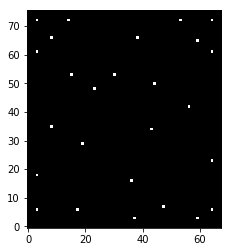

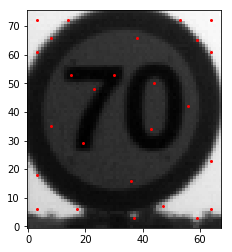

In [5]:
df = pd.read_pickle("store.pickle")
line = df.iloc[1]
rect = line.currRect
img = line.currImage

curr_points = harris_corners(rect,img,True)

mask
21.0


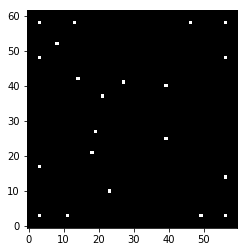

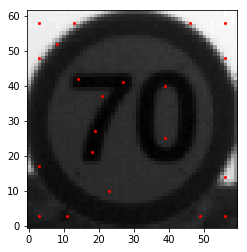

In [6]:
# df = pd.read_pickle("store.pickle")
line = df.iloc[1]
rect = line.prevRect
img = line.prevImage

prev_points = harris_corners(rect,img,True)

In [479]:
line = df.iloc[2]

In [480]:

# rect = line.currRect
# img = line.currImage
curr_points = harris_corners(line.currRect,line.currImage)


curr_meImg = MEImage.from_file(line.currImage)
curr_rect_mat = curr_meImg.im[line.currRect[2]:line.currRect[3],line.currRect[0]:line.currRect[1]]


(21,18)
(25,39)
(27,19)
(37,21)
(40,39)
(41,27)
(42,14)
[(21, 18), (25, 39), (27, 19), (37, 21), (40, 39), (41, 27), (42, 14)]


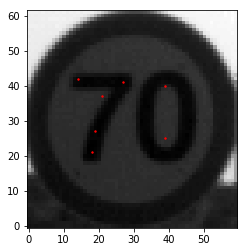

In [481]:

plt.figure()
plt.imshow(curr_rect_mat,cmap='gray',origin='lower')

final_curr = []
for x in range(curr_points.shape[0]):
            for y in range(curr_points.shape[1]):
                if curr_points[x][y]:
                    if (x > (curr_points.shape[0]*0.2)) and (x < (curr_points.shape[0]*0.8)):
                        if (y > (curr_points.shape[1]*0.2)) and (y < (curr_points.shape[1]*0.8)):
                            print(f"({x},{y})")
                            plt.scatter(y,x, c='r', s=2)
                            final_curr.append((x,y))
print(final_curr)

In [482]:
# line = df.iloc[0]
# rect = line.prevRect
# img = line.prevImage
prev_points = harris_corners(line.prevRect,line.prevImage)

prev_meImg = MEImage.from_file(line.prevImage)
prev_rect_mat = prev_meImg.im[line.prevRect[2]:line.prevRect[3],line.prevRect[0]:line.prevRect[1]]

(18,17)
(19,36)
(31,19)
(35,24)
(35,36)
(36,12)
[(18, 17), (19, 36), (31, 19), (35, 24), (35, 36), (36, 12)]


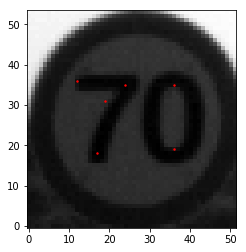

In [483]:
plt.figure()
plt.imshow(prev_rect_mat,cmap='gray',origin='lower')

final_prev = []
for x in range(prev_points.shape[0]):
            for y in range(prev_points.shape[1]):
                if prev_points[x][y]:
                    if (x > (prev_points.shape[0]*0.2)) and (x < (prev_points.shape[0]*0.8)):
                        if (y > (prev_points.shape[1]*0.2)) and (y < (prev_points.shape[1]*0.8)):
                            print(f"({x},{y})")
                            plt.scatter(y,x, c='r', s=2)
                            final_prev.append((x,y))
print(final_prev)

In [484]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = abs(nodes - node)
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

In [485]:
relative_points = []

for prev_point in final_prev:
    point = ()

In [486]:
y_measure = abs(curr_points.shape[1]/prev_points.shape[1])
x_measure = abs(curr_points.shape[0]/prev_points.shape[0])

In [487]:
colors=['red','green','blue','yellow','white','pink','orange','blue','yellow','white']
pairs = []
# final_curr = list(final_curr)

In [488]:
for ppoint in final_prev:
    new_p = (ppoint[0]*x_measure,ppoint[1]*y_measure)
    p_obj = {
        'prev':ppoint,
        'curr':final_curr[closest_node(new_p,final_curr)],
        'color':colors[len(pairs)],
    }
    pairs.append(p_obj)

In [489]:
print(pairs)
print(final_prev)
print(final_curr)

[{'prev': (18, 17), 'curr': (21, 18), 'color': 'red'}, {'prev': (19, 36), 'curr': (25, 39), 'color': 'green'}, {'prev': (31, 19), 'curr': (37, 21), 'color': 'blue'}, {'prev': (35, 24), 'curr': (41, 27), 'color': 'yellow'}, {'prev': (35, 36), 'curr': (40, 39), 'color': 'white'}, {'prev': (36, 12), 'curr': (42, 14), 'color': 'pink'}]
[(18, 17), (19, 36), (31, 19), (35, 24), (35, 36), (36, 12)]
[(21, 18), (25, 39), (27, 19), (37, 21), (40, 39), (41, 27), (42, 14)]


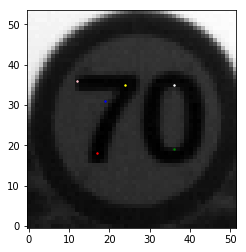

In [490]:
plt.figure()
plt.imshow(prev_rect_mat,cmap='gray',origin='lower')

for pair in pairs:
    plt.scatter(pair['prev'][1],pair['prev'][0], c=pair['color'], s=2)


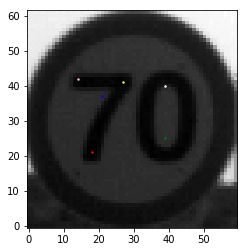

In [491]:
plt.figure()
plt.imshow(curr_rect_mat,cmap='gray',origin='lower')

for pair in pairs:
    plt.scatter(pair['curr'][1],pair['curr'][0], c=pair['color'], s=2)


In [492]:
points_in_images = []

for pair in pairs:
    new_pair = {
        'prev':(pair['prev'][0]+line.prevRect[2],pair['prev'][1]+line.prevRect[0]),
        'curr':(pair['curr'][0]+line.currRect[2],pair['curr'][1]+line.currRect[0]),
        'color':pair['color'],
    }
    points_in_images.append(new_pair)

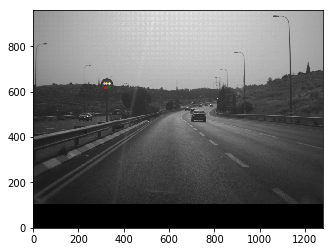

In [493]:
plt.figure()
plt.imshow(prev_meImg.im,cmap='gray',origin='lower')

for pair in points_in_images:
    plt.scatter(pair['prev'][1],pair['prev'][0], c=pair['color'], s=2)

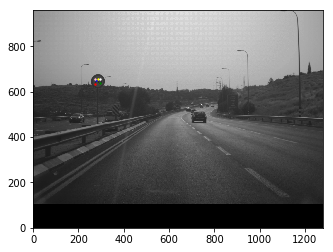

In [494]:
plt.figure()
plt.imshow(curr_meImg.im,cmap='gray',origin='lower')

for pair in points_in_images:
    plt.scatter(pair['curr'][1],pair['curr'][0], c=pair['color'], s=2)

In [495]:
print(points_in_images)

[{'prev': (623, 316), 'curr': (636, 275), 'color': 'red'}, {'prev': (624, 335), 'curr': (640, 296), 'color': 'green'}, {'prev': (636, 318), 'curr': (652, 278), 'color': 'blue'}, {'prev': (640, 323), 'curr': (656, 284), 'color': 'yellow'}, {'prev': (640, 335), 'curr': (655, 296), 'color': 'white'}, {'prev': (641, 311), 'curr': (657, 271), 'color': 'pink'}]


In [567]:
ax = points_in_images[3]['prev'][0] - prev_meImg.origin[0]
ay = points_in_images[3]['prev'][1] - prev_meImg.origin[1]
af = line.focal
prev_point_vec = np.array([[ax],[ay],[af]])
prev_point_vec

array([[  28],
       [-185],
       [1612]], dtype=int64)

In [568]:
bx = points_in_images[3]['curr'][0] - curr_meImg.origin[0]
by = points_in_images[3]['curr'][1] - curr_meImg.origin[1]
bf = line.focal
curr_point_vec = np.array([[bx],[by],[bf]])
curr_point_vec

array([[  44],
       [-224],
       [1612]], dtype=int64)

In [569]:
R_mat = line.egoMotion[0:3,0:3]
R_mat

array([[ 9.99999887e-01,  4.69688477e-04,  7.42729400e-05],
       [-4.69526179e-04,  9.99997535e-01, -2.17027886e-03],
       [-7.52921118e-05,  2.17024375e-03,  9.99997642e-01]])

In [570]:
T_vec = line.egoMotion[:3,3:4]
T_vec

array([[ 0.0569972 ],
       [-0.04871089],
       [-2.88552559]])

In [571]:
# rot_a_vec = line.egoMotion[0:3,0:3] @ a_vec
# rot_a_vec
# T_vec = line.egoMotion[:3,3:4]
# T_vec
# B = T_vec * -1
# B.T
# A = np.concatenate((rot_a_vec,-b_vec), axis=0)
# A = A.reshape(2,3)
# A = A.T
# A
# np.linalg.solve(A[0:2,0:2], B[0:2])
# prev_meImg.origin
# B.reshape(3,).shape
# # B.shape
# CC = np.concatenate((rot_a_vec,-b_vec,B.reshape(3,)),axis=0)
# CC
# # -b_vec
# CC = CC.reshape(3,3)
# CC.T
# linalg.solve(A,B)
# q, r = np.linalg.qr(CC)
# st = solve_triangular(CC, lower=True)

In [572]:
vec_1 = R_mat @ prev_point_vec
vec_1

array([[  28.03283245],
       [-188.51118018],
       [1611.59259593]])

In [573]:
vec_2 = curr_point_vec
vec_2

array([[  44],
       [-224],
       [1612]], dtype=int64)

In [574]:
df['Z']

0    13.85
1     16.7
2     None
Name: Z, dtype: object

In [575]:
e = np.array([0.00001,0.00001,0.00001]).reshape(3,1)

In [576]:
 a = np.concatenate([vec_1, vec_2],axis=1)

In [577]:
b = np.concatenate([vec_1, vec_2,e],axis=1)

In [578]:
tt = np.linalg.solve(b, T_vec)
t = tt[1]
s = tt[0]
print(t)
print(s)

[0.00948205]
[-0.01124705]


In [579]:
t*line.focal

array([15.28507086])

In [580]:
s*line.focal

array([-18.13025217])

In [581]:
df['Z']

0    13.85
1     16.7
2     None
Name: Z, dtype: object

In [582]:
from numpy.linalg import inv

In [583]:
ls = inv((a.T@a))@a.T@T_vec
lt = ls[1]
ls = ls[0]

In [584]:
lt*line.focal

array([16.42171201])

In [585]:
ls*line.focal

array([-19.31016218])